In [1]:
import os
import sys
import errno
import re
import glob
import os.path as op
import json
from datetime import datetime, timedelta, date
from IPython.display import display, clear_output, HTML
import numpy as np
from pathlib import Path
import pandas as pd
from osgeo import osr, ogr, gdal
from osgeo.gdalnumeric import *
from osgeo.gdalconst import *
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import matplotlib.gridspec as pltg
import matplotlib.transforms as matptrans
import seaborn as sn
from matplotlib.colors import LogNorm
import calendar
import xml.etree.ElementTree as ET
import zipfile
import random
from pyproj import Proj, transform
from pyproj.transformer import Transformer
from datetime import datetime, timedelta
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error

import warnings
import copy
import pickle

warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 

In [2]:
def mkdir_p(dos):
    try:
        os.makedirs(dos)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(dos):
            pass
        else:
            raise
            
def getDateFromStr(N):
    sepList = ["","-","_","/"]
    date = ''
    for s in sepList :
        found = re.search('\d{4}'+ s +'\d{2}'+ s +'\d{2}', N)
        if found != None :
           date = datetime.strptime(found.group(0), '%Y'+ s +'%m'+ s +'%d').date()
           break
    return date
    
def getTileFromStr(N):

    tile = ''
    found = re.search('\d{2}' +'[A-Z]{3}', N)
    if found != None : tile = found.group(0)
    return tile
# reproject the coord of a point from inEPSG to outEPSG
def reproject(inEPSG,outEPSG,x1,y1):  
    #transformer = Transformer.from_crs(int(inEPSG),int(outEPSG))
    #x2,y2 = transformer.transform(y1, x1)
    inProj = Proj(init='EPSG:' + inEPSG)
    outProj = Proj(init='EPSG:'+ outEPSG)
    x2,y2 = transform(inProj,outProj,x1,y1)
    #print("REPROJECT")
    #print(inEPSG,x1,y1)
    #print(outEPSG,x2,y2)
    return [x2, y2]

def getSPOTGRSFromStr(N):
    K = ''
    J = ''
    found = re.search('_'+'\d{3}'+'-' +'\d{3}'+'-'+'\d{1}', N)
    if found != None : 
        GRS = found.group(0)
        GRS_s = GRS.split('-')
        K = int(GRS_s[0][1:])
        J = int(GRS_s[1])
        S = int(GRS_s[2])
    
    return K,J,S

def getCoords(G):
    
    
    GT = G.GetGeoTransform()
    minx = GT[0]
    maxy = GT[3]
    maxx = minx + GT[1] * G.RasterXSize
    miny = maxy + GT[5] * G.RasterYSize
    
    return minx, maxy, maxx, miny

In [3]:
S2_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':600000,'MINY':4690200,'MAXX':709800,'MAXY':4800000},
        '30TYN':{'EPSG':'32630','MINX':699960,'MINY':4690200,'MAXX':809760,'MAXY':4800000},
        '31TCH':{'EPSG':'32631','MINX':300000,'MINY':4690200,'MAXX':409800,'MAXY':4800000},
        '31TDH':{'EPSG':'32631','MINX':399960,'MINY':4690200,'MAXX':509760,'MAXY':4800000}
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':699960,'MINY':4790220,'MAXX':809760,'MAXY':4900020},
        '31TGK':{'EPSG':'32631','MINX':699960,'MINY':4890240,'MAXX':809760,'MAXY':5000040},
        '31TGL':{'EPSG':'32631','MINX':699960,'MINY':4990200,'MAXX':809760,'MAXY':5100000},
        '31TGM':{'EPSG':'32631','MINX':699960,'MINY':5090220,'MAXX':809760,'MAXY':5200020},
        "32TLP":{'EPSG':'32632','MINX':300000,'MINY':4790220,'MAXX':409800,'MAXY':4900020},
        '32TLQ':{'EPSG':'32632','MINX':300000,'MINY':4890240,'MAXX':409800,'MAXY':5000040},
        '32TLR':{'EPSG':'32632','MINX':300000,'MINY':4990200,'MAXX':409800,'MAXY':5100000},
        '32TLS':{'EPSG':'32632','MINX':300000,'MINY':5090220,'MAXX':409800,'MAXY':5200020}
    }
}





S2_4326_tiles={
    "PYR":
    {
        "30TXN":{'EPSG':'32630','MINX':reproject('32630','4326',600000,4690200)[0],'MINY':reproject('32630','4326',600000,4690200)[1],'MAXX':reproject('32630','4326',709800,4800000)[0],'MAXY':reproject('32630','4326',709800,4800000)[1]
                },
        '30TYN':{'EPSG':'32630','MINX':reproject('32630','4326',699960,4690200)[0],'MINY':reproject('32630','4326',699960,4690200)[1],'MAXX':reproject('32630','4326',809760,4800000)[0],'MAXY':reproject('32630','4326',809760,4800000)[1]
                },
        '31TCH':{'EPSG':'32631','MINX':reproject('32631','4326',300000,4690200)[0],'MINY':reproject('32631','4326',300000,4690200)[1],'MAXX':reproject('32631','4326',409800,4800000)[0],'MAXY':reproject('32631','4326',409800,4800000)[1]
                },
        '31TDH':{'EPSG':'32631','MINX':reproject('32631','4326',399960,4690200)[0],'MINY':reproject('32631','4326',399960,4690200)[1],'MAXX':reproject('32631','4326',509760,4800000)[0],'MAXY':reproject('32631','4326',509760,4800000)[1]
                }
    },
    "ALP":
    {
        "31TGJ":{'EPSG':'32631','MINX':reproject('32631','4326',699960,4790220)[0],'MINY':reproject('32631','4326',699960,4790220)[1],'MAXX':reproject('32631','4326',809760,4900020)[0],'MAXY':reproject('32631','4326',809760,4900020)[1]
                },
        '31TGK':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4890240)[0],'MINY':reproject('32631','4326',699960,4890240)[1],'MAXX':reproject('32631','4326',809760,5000040)[0],'MAXY':reproject('32631','4326',809760,5000040)[1]
                },
        '31TGL':{'EPSG':'32631','MINX':reproject('32631','4326',699960,4990200)[0],'MINY':reproject('32631','4326',699960,4990200)[1],'MAXX':reproject('32631','4326',809760,5100000)[0],'MAXY':reproject('32631','4326',809760,5100000)[1]
                },
        '31TGM':{'EPSG':'32631','MINX':reproject('32631','4326',699960,5090220)[0],'MINY':reproject('32631','4326',699960,5090220)[1],'MAXX':reproject('32631','4326',809760,5200020)[0],'MAXY':reproject('32631','4326',809760,5200020)[1]
                },
        "32TLP":{'EPSG':'32632','MINX':reproject('32632','4326',300000,4790220)[0],'MINY':reproject('32632','4326',300000,4790220)[1],'MAXX':reproject('32632','4326',409800,4900020)[0],'MAXY':reproject('32632','4326',409800,4900020)[1]
                },
        '32TLQ':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4890240)[0],'MINY':reproject('32632','4326',300000,4890240)[1],'MAXX':reproject('32632','4326',409800,5000040)[0],'MAXY':reproject('32632','4326',409800,5000040)[1]
                },
        '32TLR':{'EPSG':'32632','MINX':reproject('32632','4326',300000,4990200)[0],'MINY':reproject('32632','4326',300000,4990200)[1],'MAXX':reproject('32632','4326',409800,5100000)[0],'MAXY':reproject('32632','4326',409800,5100000)[1]
                },
        '32TLS':{'EPSG':'32632','MINX':reproject('32632','4326',300000,5090220)[0],'MINY':reproject('32632','4326',300000,5090220)[1],'MAXX':reproject('32632','4326',409800,5200020)[0],'MAXY':reproject('32632','4326',409800,5200020)[1]
                }
    }
}



LANDSAT_tiles={
    "ALP":
    {
        "195029":["31TGJ",'31TGK','31TGL',"32TLP",'32TLQ','32TLR'],
        "195028":['31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "196029":["31TGJ",'31TGK','31TGL','32TLQ','32TLR'],
        "196028":['31TGK','31TGL','31TGM','32TLQ','32TLR','32TLS'],
        "194029":["32TLP",'32TLQ','32TLR']
    },
    "PYR":
    {
        "200030":["30TXN",'30TYN'],
        "199030":["30TXN",'30TYN','31TCH'],
        "198031":['31TCH','31TDH'],
        "198030":['31TCH','31TDH'],
        "197031":['31TDH']
    }
}

LANDSAT_tiles_2={
    "ALP":
    {
        "31TGJ":["195029","196029"],
        '31TGK':["195029","196029","196028"],
        '31TGL':["195029","195028","196029","196028"],
        '31TGM':["195028","196028"],
        "32TLP":["194029","195029"],
        '32TLQ':["194029","195029","195028","196029","196028"],
        '32TLR':["194029","195029","195028","196029","196028"],
        '32TLS':["195028","196028"]
    },
    "PYR":
    {
        "30TXN":["200030","199030"],
        '30TYN':["200030","199030"],
        '31TCH':["199030","198031","198030"],
        '31TDH':["198031","198030","197031"]
    }
}

SPOT_tile={
    "ALP":
    {"KMIN":46,
     "KMAX":55,
     "JMIN":254,
     "JMAX":263
    },
    "PYR":
    {"KMIN":35,
     "KMAX":48,
     "JMIN":262,
     "JMAX":265
    }
}

In [4]:
SWH_path = "/datalake/theia/prod/SPOTWORLDHERITAGE"
points_shp_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/stations_tcd_50_massifs_prec4_nodoubles.shp"
srs =  osr.SpatialReference()
srs.ImportFromEPSG(4326)
drv = ogr.GetDriverByName( 'ESRI Shapefile' )
points_shp = drv.Open(points_shp_path)

layer_points = points_shp.GetLayer()
featureCount = layer_points.GetFeatureCount()
print(featureCount)


ERROR 1: PROJ: proj_create_from_database: Cannot find proj.db


276


In [9]:
#start over
df_swh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/df_swh_acquis_new.pkl"
df = pd.DataFrame()   
df.to_pickle(df_swh_path)

In [ ]:
#load
df_swh_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_acquis_new.pkl"
with open( df_swh_path, "rb" )  as dp:
    df = pickle.load(dp)  
if not df.empty:
    print(df["YEAR"].unique())
    print(df)

In [ ]:
#get days of spot acqui per year per tile

temp_shp = "/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/SWH_CARTO_PROJECT/tmp/temp.shp"






for year in range(2007,2010):
    d = dict()
    d["ID"] = []
    d["YEAR"] = []
    d["MONTH"] = []
    d["SEASON"] = []
    d["DAY"] = []
    d["MTN"] = []
    d["TILE"] = []
    year = str(year)
    for month in os.listdir(SWH_path+"/"+year):
        m = int(month)
        season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
        for day in os.listdir(SWH_path+"/"+year+"/"+month):
            for product in os.listdir(SWH_path+"/"+year+"/"+month+"/"+day):
                K,J,S = getSPOTGRSFromStr(product)
                for mtn in ["PYR","ALP"]:
                    if K <= SPOT_tile[mtn]["KMAX"] and K >= SPOT_tile[mtn]["KMIN"] and J <= SPOT_tile[mtn]["JMAX"] and J >= SPOT_tile[mtn]["JMIN"] :
                        for zipswh in os.listdir(SWH_path+"/"+year+"/"+month+"/"+day+"/"+product):
                            swh_date = getDateFromStr(zipswh)
                            if swh_date < date(int(swh_date.year),9,1):
                                annee_hydro = int(swh_date.year) - 1
                            else:
                                annee_hydro = int(swh_date.year)
                            date_debut_hydro = date(annee_hydro,9,1)
                            annee_hydro_jour = (swh_date - date_debut_hydro).days + 1
                            zip_scene = zipfile.ZipFile(SWH_path+"/"+year+"/"+month+"/"+day+"/"+product+"/"+zipswh)
                            for ziped_file in zip_scene.namelist():
                                if "XS1" in os.path.basename(ziped_file) and ".tif.aux.xml" not in ziped_file :

                                    xs1_path = "/vsizip/"+SWH_path+"/"+year+"/"+month+"/"+day+"/"+product+"/"+zipswh+"/"+ziped_file
                                    xs1 = gdal.Open(xs1_path)
                                    #get xs1 geometry (including nodatas)
                                    minx1, maxy1, maxx1, miny1 = getCoords(xs1)
                                    

                                    for tile in ["31TCH"]:

                                        minx2,miny2 = S2_4326_tiles[mtn][tile]["MINX"],S2_4326_tiles[mtn][tile]["MINY"]
                                        maxx2,maxy2 = S2_4326_tiles[mtn][tile]["MAXX"],S2_4326_tiles[mtn][tile]["MAXY"]
                                        minx3 = max(minx1,minx2)
                                        maxy3 = min(maxy1,maxy2)
                                        maxx3 = min(maxx1,maxx2)
                                        miny3 = max(miny1,miny2)  
                                        #print(miny1,maxy1,minx1,maxx1,miny2,maxy2,minx2,maxx2)

                                        # no intersection 
                                        if (minx3 > maxx3 or miny3 > maxy3) : 
                                            continue
                                        else:
                                            
                                            xs1_c =  gdal.GetDriverByName('MEM').Create('', xs1.RasterXSize, xs1.RasterYSize, 1, gdal.GDT_UInt16) 
                                            xs1_c.SetProjection(xs1.GetProjection())
                                            xs1_c.SetGeoTransform(xs1.GetGeoTransform())

                                            band_xs1 = xs1.GetRasterBand(1)
                                            band_xs1_c = xs1_c.GetRasterBand(1)
                                            array_xs1 = BandReadAsArray(band_xs1)
                                            array_xs1[array_xs1 > 0] = 1
                                            band_xs1_c.WriteArray(array_xs1)

                                            xs1_layername = "temp_shp"
                                            xs1_ds = drv.CreateDataSource(temp_shp)
                                            xs1_layer = xs1_ds.CreateLayer(xs1_layername, srs, ogr.wkbPolygon)
                                            gdal.Polygonize( band_xs1_c, band_xs1_c, xs1_layer, -1, [], callback=None )
                                            for feature_xs1 in xs1_layer:
                                                geom_xs1 = feature_xs1.GetGeometryRef().Simplify(0.001)
                                                for feature in layer_points:
                                                    if tile == feature['tile']:
                                                        point = feature.GetGeometryRef()        
                                                        if geom_xs1.Contains(point):
                                                            d["YEAR"].append(annee_hydro)
                                                            d["DAY"].append(annee_hydro_jour)
                                                            d["MONTH"].append(m)
                                                            d["SEASON"].append(season)
                                                            d["TILE"].append(tile)
                                                            d["MTN"].append(mtn)

                                                            d["ID"].append(feature['id'])

                                            
                                            
                                            
                                            os.system("rm "+temp_shp)


    print(year,len(d['ID']))

    df2 = pd.DataFrame(data=d)   
    df2["COLLECTION"]="SWH"
   
            
    df = pd.concat([df, df2], ignore_index=True)
    df.to_pickle(df_swh_path)
                            

In [ ]:
#get days of landsat acqui per year per tile
LANDSAT_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR"
df_swh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/df_swh_acquis.pkl"
df_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/df_swh_landsat_acquis.pkl"
temp_shp = "/work/CAMPUS/etudes/Neige/CoSIMS/zacharie/SWH_CARTO_PROJECT/tmp/temp.shp"
d = dict()
d["ID"] = []
d["YEAR"] = []
d["MONTH"] = []
d["SEASON"] = []
d["DAY"] = []
d["MTN"] = []
d["TILE"] = []
d["SAFRAN"] = []
d["SAFRAN_S"] = []

for mtn in ["PYR"]:
    print(mtn)
    for wrs in LANDSAT_tiles[mtn]:
        print(wrs)
        if "31TCH" not in LANDSAT_tiles[mtn][wrs]:continue
        for product in os.listdir(LANDSAT_path+"/"+mtn+"/"+wrs):

            landsat_date = getDateFromStr(product)
            if landsat_date.year < 1986 or landsat_date.year > 2015: continue
            m = landsat_date.month
            season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
            if landsat_date < date(int(landsat_date.year),9,1):
                annee_hydro = int(landsat_date.year) - 1
            else:
                annee_hydro = int(landsat_date.year)
            date_debut_hydro = date(annee_hydro,9,1)
            annee_hydro_jour = (landsat_date - date_debut_hydro).days + 1
            
            
            #xs1 = gdal.Open(LANDSAT_path+"/"+mtn+"/"+wrs+"/"+product)
            #print(xs1)
            xs1 = gdal.Open(LANDSAT_path+"/"+mtn+"/"+wrs+"/"+product)
            if "LE07" in product:
                xs1 = gdal.Warp('',xs1,format='MEM',resampleAlg="average",xRes=1000,yRes=1000)
            xs1 = gdal.Warp('',xs1,format='MEM',resampleAlg="near",dstSRS="EPSG:4326")
            xs1_c =  gdal.GetDriverByName('MEM').Create('', xs1.RasterXSize, xs1.RasterYSize, 1, gdal.GDT_Byte) 
            xs1_c.SetProjection(xs1.GetProjection())
            xs1_c.SetGeoTransform(xs1.GetGeoTransform())
            #print("binarize")
            band_xs1 = xs1.GetRasterBand(1)
            band_xs1_c = xs1_c.GetRasterBand(1)
            array_xs1 = BandReadAsArray(band_xs1)
            array_xs1[array_xs1 > 0] = 1
            band_xs1_c.WriteArray(array_xs1)
            #print("polygonize")
            xs1_layername = "temp_shp"
            xs1_ds = drv.CreateDataSource(temp_shp)
            xs1_layer = xs1_ds.CreateLayer(xs1_layername, srs, ogr.wkbPolygon)
            gdal.Polygonize( band_xs1_c, band_xs1_c, xs1_layer, -1, [], callback=None )
            
            
            #polygns to multipolygons:
            #print("multipolygon")
            geom = ogr.Geometry(ogr.wkbMultiPolygon)
            for feature_xs1 in xs1_layer:
                geom.AddGeometry(feature_xs1.GetGeometryRef().Simplify(0.001))
            contain = 0
            #print("check points")
            for feature in layer_points:
                if wrs in feature['WRS'] and '31TCH' in feature['tile']:
                    point = feature.GetGeometryRef() 
                    if geom.Contains(point):
                        contain+=1
                        d["YEAR"].append(annee_hydro)
                        d["DAY"].append(annee_hydro_jour)
                        d["TILE"].append(feature['tile'])
                        d["MTN"].append(mtn)
                        d["SAFRAN"].append(feature['safran'])
                        d["ID"].append(feature['id'])
                        d["SAFRAN_S"].append(feature['safran_s'])
                        d["MONTH"].append(m)
                        d["SEASON"].append(season)
                        
            
            
            
        
      
            print(product,"nb of features:",xs1_layer.GetFeatureCount(),"nb of points:",contain)
            
            os.system("rm "+temp_shp)
            
            
            


df2 = pd.DataFrame(data=d)   
df2["COLLECTION"]="LANDSAT"
df1= pd.DataFrame()   
with open( df_swh_path, "rb" )  as df:
    df1 = pickle.load(df)              
df = pd.concat([df1, df2], ignore_index=True)
df.to_pickle(df_path)

In [ ]:
df_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/df_swh_landsat_acquis.pkl"
with open( df_path, "rb" )  as df:
    df = pickle.load(df)  
df = df[["YEAR","SEASON","DAY","ID","COLLECTION"]]
df = df.query("YEAR >= 1986 & YEAR < 2014")
df = df.drop_duplicates()
df["NOBS"]  =1

#sn.kdeplot(data = df.query("YEAR >= 1986 & YEAR < 1990"), x = "DAY")
#sn.kdeplot(data = df.query("YEAR >= 1990 & YEAR < 1995"), x = "DAY")
#sn.kdeplot(data = df.query("YEAR >= 1995 & YEAR < 2000"), x = "DAY")
#sn.kdeplot(data = df.query("YEAR >= 2005 & YEAR < 2010"), x = "DAY")
#sn.kdeplot(data = df.query("YEAR >= 2010 & YEAR < 2015"), x = "DAY")
sn.kdeplot(data = df, x = "DAY",hue="COLLECTION")






In [6]:
df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_landsat_acquis.pkl"
with open( df_path, "rb" )  as df:
    df = pickle.load(df)
df

,ID,YEAR,MONTH,SEASON,DAY,MTN,TILE,SAFRAN,SAFRAN_S,COLLECTION
0,700.0,2009.0,2.0,WINTER,177.0,PYR,31TCH,Couserans,Couse,SWH
1,703.0,2009.0,2.0,WINTER,177.0,PYR,31TCH,Couserans,Couse,SWH
2,704.0,2009.0,2.0,WINTER,177.0,PYR,31TCH,Couserans,Couse,SWH
3,706.0,2009.0,2.0,WINTER,177.0,PYR,31TCH,Couserans,Couse,SWH
4,707.0,2009.0,2.0,WINTER,177.0,PYR,31TCH,Couserans,Couse,SWH
...,...,...,...,...,...,...,...,...,...,...
1391930,1581.0,1991.0,4.0,SPRING,226.0,PYR,31TCH,Orlu St-Barthelemy,OrSBa,LANDSAT
1391931,1593.0,1991.0,4.0,SPRING,226.0,PYR,31TCH,Orlu St-Barthelemy,OrSBa,LANDSAT
1391932,1594.0,1991.0,4.0,SPRING,226.0,PYR,31TCH,Orlu St-Barthelemy,OrSBa,LANDSAT
1391933,1597.0,1991.0,4.0,SPRING,226.0,PYR,31TCH,Orlu St-Barthelemy,OrSBa,LANDSAT


In [15]:
df_both_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/INSITU/STATIONS/df_swh_landsat_acquis_stations.pkl"
with open( df_both_path, "rb" )  as dp:
    df = pickle.load(dp)
    
df["SEASON"] =    np.where((df["MONTH_N"].isin([9,10,11])),"AUTUMN",np.where((df["MONTH_N"].isin([12,1,2])),"WINTER",np.where((df["MONTH_N"].isin([3,4,5])),"SPRING","SUMMER")))
df_u_sta_sat = df.loc[df.drop(columns=["TILE","CLASS"]).drop_duplicates().index]  
df_u_sta = df.loc[df.drop(columns=["TILE","CLASS","COLLECTION"]).drop_duplicates().index]  
print(df_u_sta_sat)
print(df_u_sta)

              ID  YEAR MONTH  DAY  MTN   TILE           SAFRAN SAFRAN_S  \
0       64316002  2002   Jul  322  PYR  30TXN      Pays-Basque    P-Bas   
1       64316400  2002   Jul  322  PYR  30TXN      Pays-Basque    P-Bas   
2       64316002  2002   Jul  312  PYR  30TXN      Pays-Basque    P-Bas   
3       64316400  2002   Jul  312  PYR  30TXN      Pays-Basque    P-Bas   
4       64316002  2002   Jun  280  PYR  30TXN      Pays-Basque    P-Bas   
...          ...   ...   ...  ...  ...    ...              ...      ...   
781434  73023001  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781435  73322401  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781436  73157002  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781437  73026001  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   
781438  73157400  2011   Oct   61  ALP  32TLR  Haute-Maurienne    H-Mau   

         CLASS  SD_SIM  SD_OBS COLLECTION  MONTH_N  SEASON  
0       GROUND     0.0     0.0        

10 127
     SEASON         ID      ACQUI
0    AUTUMN    9029400  10.862069
1    AUTUMN    9135400   8.689655
2    AUTUMN    9139400  13.689655
3    AUTUMN    9139402  13.931034
4    AUTUMN    9162001   8.827586
..      ...        ...        ...
331  WINTER   99130413   9.379310
332  WINTER  203000444  16.551724
333  WINTER  203017014  11.206897
334  WINTER  203017018  11.620690
335  WINTER  203025064  11.448276

[336 rows x 3 columns]
{'AUTUMN': 0.24666144194515605, 'SPRING': 0.24756991964066397, 'SUMMER': 0.3049443801101871, 'WINTER': 0.20082425830399306}
{'AUTUMN': 0.2479267609141372, 'WINTER': 0.3045148671795547, 'SPRING': 0.24701697376092835, 'SUMMER': 0.2005413981453797}


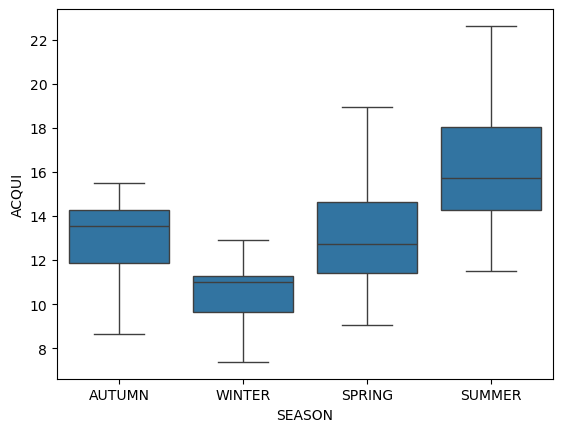

In [38]:
# make seasonal weigth range and get min and max NOBS
#df_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_swh_landsat_acquis.pkl"
#with open( df_path, "rb" )  as df:
#    df = pickle.load(df)

df = df_u_sta.query("YEAR >= 1986 & YEAR < 2015 & MTN == 'PYR'")
df = df[["YEAR","SEASON","DAY","ID"]]

df = df.drop_duplicates()

df["ACQUI"]  =1
df_minmax = df[["YEAR","ID","ACQUI"]].groupby(["YEAR","ID"], as_index=False).sum()


min_obs = df_minmax["ACQUI"].min()
max_obs = df_minmax["ACQUI"].max()
print(min_obs,max_obs)

df_seasons = df[["SEASON","ID","ACQUI"]].groupby(["SEASON","ID"], as_index=False).sum()
df_years =  df[["SEASON","ID","YEAR"]].groupby(["SEASON","ID"], as_index=False).nunique()
df_seasons["ACQUI"] = df_seasons["ACQUI"].div(df_years['YEAR'])
print(df_seasons)
fig, ax = plt.subplots()
sn.boxplot(data = df_seasons, x = "SEASON",y="ACQUI",order=["AUTUMN","WINTER","SPRING","SUMMER"],showfliers=False)
plt.savefig("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/PLOTS/seasons.pdf",format="pdf")

df = df_seasons[["SEASON","ACQUI"]].groupby(["SEASON"], as_index=False).mean()
df["WEIGHT"] = df["ACQUI"]/df["ACQUI"].sum()
dict_weights = dict(zip(df["SEASON"], df["WEIGHT"]))
dict_inverse_weights = dict()
v0= (1/dict_weights["AUTUMN"])
v1=(1/dict_weights["WINTER"])
v2=(1/dict_weights["SPRING"])
v3=(1/dict_weights["SUMMER"])
t=v0+v1+v2+v3
dict_inverse_weights["AUTUMN"]=(v0/t)
dict_inverse_weights["WINTER"]=(v1/t)
dict_inverse_weights["SPRING"]=(v2/t)
dict_inverse_weights["SUMMER"]=(v3/t)




        
print(dict_weights)
print(dict_inverse_weights)

In [ ]:
# simulate SMOD from a pixel

year=365
start_hydro = date(2017,9,1)
start_autumn = 0
end_autumn = (date(2017,12,1) - start_hydro).days - 1
start_winter = end_autumn+1
end_winter = (date(2018,3,1) - start_hydro).days - 1
start_spring = end_winter + 1
end_spring = (date(2018,6,1) - start_hydro).days - 1
start_summer = end_spring + 1
end_summer = (date(2018,9,1) - start_hydro).days - 1
#print(start_autumn,end_autumn,start_winter,end_winter,start_spring,end_spring,start_summer,end_summer)

dict_inverse_weights = dict()
v0= (1/dict_weights["AUTUMN"])
v1=(1/dict_weights["WINTER"])
v2=(1/dict_weights["SPRING"])
v3=(1/dict_weights["SUMMER"])
t=v0+v1+v2+v3
dict_inverse_weights["AUTUMN"]=(v0/t)
dict_inverse_weights["WINTER"]=(v1/t)
dict_inverse_weights["SPRING"]=(v2/t)
dict_inverse_weights["SUMMER"]=(v3/t)
print(dict_inverse_weights)




year_weight = np.ones(year)
year_weight[start_autumn:end_autumn+1] = dict_inverse_weights["AUTUMN"]/len(year_weight[start_autumn:end_autumn+1])
year_weight[start_winter:end_winter+1] = dict_inverse_weights["WINTER"]/len(year_weight[start_winter:end_winter+1])
year_weight[start_spring:end_spring+1] = dict_inverse_weights["SPRING"]/len(year_weight[start_spring:end_spring+1])
year_weight[start_summer:end_summer+1] = dict_inverse_weights["SUMMER"]/len(year_weight[start_summer:end_summer+1])


d= {"INSITU_SMOD":[],"SMOD":[],"SOD":[],"INSITU_SOD":[],"ΔSMOD":[],"ΔSOD":[],"NOBS":[]}


for SOD in range(0,366):
    print("SOD",SOD)
    for SMOD in range(0,366):
        if SOD >= SMOD - 90: continue
        year_hydro = (np.zeros(year+2))
        year_hydro[SOD+1:SMOD+2] = 1
        #print(year_hydro)


        for i in range(300,365):
            list_smod = []
            list_sod = []

            for j in range(0,10):
                #print(i)
                days_to_interpolate = np.sort(np.random.choice(np.arange(1,year+1), i,p=year_weight, replace=False))
                #print("days to interpolate",days_to_interpolate)
                days_to_keep = np.delete(np.arange(0,year+2), days_to_interpolate)
                #print("days to keep",days_to_keep)
                snow_days_to_keep = year_hydro[days_to_keep]
                #print("snow days to keep",snow_days_to_keep)
                interpolation = np.interp(days_to_interpolate.astype(float), days_to_keep.astype(float), snow_days_to_keep.astype(float))

                #print("interpolation",interpolation)
                result = np.zeros(year+2)
                result[days_to_keep] = snow_days_to_keep
                result[days_to_interpolate] = np.round(interpolation)
                result = result.tolist()
                #print(len(result),result)
                #print("result",result)
                res_SMOD = 0
                res_SOD = 0
                if 1 in result:
                    res_SMOD = len(result) - 1 - result[::-1].index(1) - 1
                    res_SOD = result.index(1) - 1

                    
                delta_SMOD = res_SMOD - SMOD
                delta_SOD = res_SOD - SOD


            
                d["SMOD"].append(res_SMOD)
                d["INSITU_SOD"].append(SMOD)
                d["ΔSMOD"].append(delta_SMOD)   
                d["SOD"].append(res_SOD)
                d["INSITU_SOD"].append(SOD)
                d["ΔSOD"].append(delta_SOD)
                d["NOBS"].append(year - i)
            

          

df = pd.DataFrame(data=d)  
df["COLLECTION"]="LS_WEIGHT"

df.to_pickle("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_simu_pixel.pkl")
            





In [ ]:
df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_simu_pixel.pkl"
with open( df_syn_path, "rb" )  as dp:
    df1 = pickle.load(dp)  

df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_simu_no_pixel.pkl"
with open( df_syn_path, "rb" )  as dp:
    df2 = pickle.load(dp)  
df3=pd.concat([df1,df2],ignore_index=True)
df3.to_pickle("/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_simu_all_pixel.pkl")
print(df3)

In [4]:
df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_simu_all_pixel.pkl"
with open( df_syn_path, "rb" )  as dp:
    df = pickle.load(dp)  
    


In [5]:
df_samples = df.query("COLLECTION == 'LS_WEIGHT' & SOD <= 120 & SMOD >= 210").groupby(['INSITU_SOD','INSITU_SMOD'])[['ΔSMOD','NOBS','SMOD']].apply(lambda s: s.sample(min(len(s), 100))).reset_index()
print(df_samples)


         INSITU_SOD  INSITU_SMOD   level_2  ΔSMOD  NOBS  SMOD
0                 0           91       640    134     1   225
1                 0           92      1299    119     1   211
2                 0           92      1244    125     6   217
3                 0           92      1292    120     1   212
4                 0           93      1942    134     1   227
...             ...          ...       ...    ...   ...   ...
2516464         239          355  24251486    -28     2   327
2516465         239          361  24255330     -5     7   356
2516466         240          331  24258629     -2     3   329
2516467         240          348  24269687    -52     2   296
2516468         240          355  24274198     -2     6   353

[2516469 rows x 6 columns]


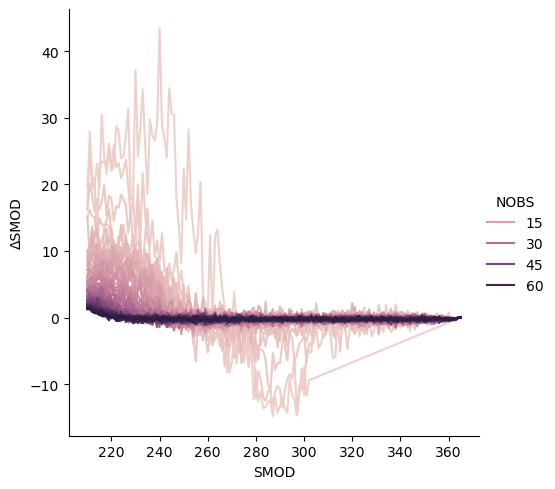

In [6]:
sn.relplot(
    data=df_samples.query("SMOD > 0 "), 
    x="SMOD", y="ΔSMOD", hue="NOBS",kind="line",errorbar=None,estimator="mean"
)

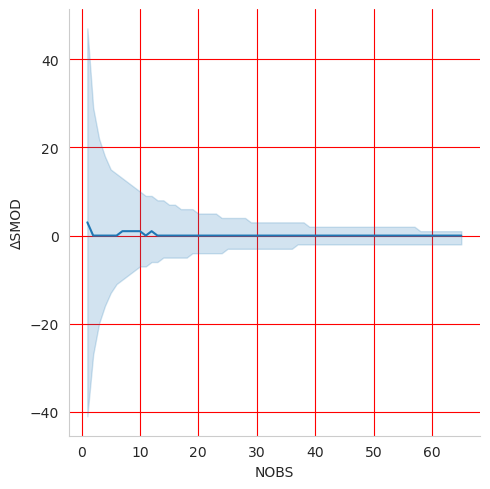

In [7]:
sn.set_style("whitegrid", {'grid.color': 'red'})
sn.relplot(
    data=df_samples.query("SMOD > 0 "), 
    x="NOBS", y="ΔSMOD",kind="line",errorbar=("pi", 50),estimator="median"
)

In [35]:
# 
tile = "30TYN"
FSC_list_path = f"/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/{tile}"
hydro_year = 2017

FSC_list = glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year)}*_[0-9]'),recursive=True) + glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year+1)}*_[0-9]'),recursive=True)
hydro_dict = {"AUTUMN":[],"WINTER":[],"SPRING":[],"SUMMER":[]}
hydro_list = []
weight_list = []

nb_of_FSC = 0
for FSC in FSC_list:
    fscdate = getDateFromStr(FSC)
    m = fscdate.month
    if fscdate >= date(hydro_year,9,2) and fscdate < date(hydro_year+1,9,1):
        season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
        hydro_dict[season].append(FSC)
        nb_of_FSC +=1
for season in hydro_dict:
    day_weight = dict_weights[season]/len(hydro_dict[season])
    for fsc in hydro_dict[season]:
        hydro_list.append(fsc)
        weight_list.append(day_weight)
        
        
print(nb_of_FSC)
print(hydro_list)
print(weight_list)
print(sum(weight_list))

102
['/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/05/FSC_20171105T110231_S2A_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/17/FSC_20171117T105314_S2B_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/07/FSC_20171107T105753_S2B_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/30/FSC_20171130T110442_S2B_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/22/FSC_20171122T105612_S2A_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/25/FSC_20171125T110358_S2A_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/20/FSC_20171120T110332_S2B_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/12/FSC_20171112T105302_S2A_T30TYN_V100_1', '/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/30TYN/2017/11/15/FSC_20171115T110620_S2A_T30

In [ ]:
#job a synthesis for every number of removal
driver = gdal.GetDriverByName('GTiff')
output_dir_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/REDUCED/LS"
mkdir_p(output_dir_path)
config_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/configs"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/logs"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
print(nb_of_FSC,max_obs,min_obs)
num_del_start = min(nb_of_FSC - 1,max_obs)
num_del_end =  min_obs
#weight_list =  ((1/(df["WEIGHT"]))/(1/(df["WEIGHT"])).sum()).values.tolist()
#print(hydro_list)
for num_keep in range(num_del_start,num_del_end -1,-1):
    print(num_keep)
    for i in range(1,5):
        common_name = f"SY-FSC_T-{tile}_HY-{str(hydro_year)}_N-{str(num_keep)}_I-{str(i)}"
        synthese_dir_path = os.path.join(output_dir_path,str(hydro_year),str(num_keep),str(i),common_name)
        mkdir_p(synthese_dir_path)
        fsc_to_keep = (np.random.choice(hydro_list, num_keep, p=weight_list, replace=False)).tolist()
        
        
        #add zero image at each first september
        nodata_path_first = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
        nodata_tif_first = os.path.join(nodata_path_first,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif")
        if not os.path.exists(nodata_tif_first):
            mkdir_p(nodata_path_first)
            nodata_array = np.zeros((5490,5490))
            outDs = driver.Create(nodata_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
            geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
            outBand = outDs.GetRasterBand(1)
            outBand.WriteArray(nodata_array)
            outDs.SetGeoTransform(geotransform) 
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
            outDs.SetProjection(srs.ExportToWkt())
            outDs.FlushCache()   
        fsc_to_keep.append(nodata_path_first)
        
        
        nodata_path_last = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}")
        nodata_tif_last = os.path.join(nodata_path_last,f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}_FSCTOC.tif")
        if not os.path.exists(nodata_tif_last):
            nodata_array = np.zeros((5490,5490))
            mkdir_p(nodata_path_last)
            outDs = driver.Create(nodata_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
            geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
            outBand = outDs.GetRasterBand(1)
            outBand.WriteArray(nodata_array)
            outDs.SetGeoTransform(geotransform) 
            srs = osr.SpatialReference()
            srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
            outDs.SetProjection(srs.ExportToWkt())
            outDs.FlushCache()   
        fsc_to_keep.append(nodata_path_last)
        
        
        
        
        season_count = {"AUTUMN":0,"WINTER":0,"SPRING":0,"SUMMER":0}
        config = {
            "ram": 4096,
            "nb_threads": "8",
            "log_level": "INFO",
            }
        config["tile_id"]=tile
        config["date_start"]=(date(hydro_year,9,1)).strftime('%d/%m/%Y')
        config["date_stop"]=(date(hydro_year+1,9,1)).strftime('%d/%m/%Y')
        config["output_dates_filename"]= f"{common_name}.txt"
        config["date_margin"]=0
        config["input_products_list"]= fsc_to_keep
        config["config_file"]= f"{config_path}/{common_name}.json"
        config["output_dir"]= synthese_dir_path
        json_object = json.dumps(config, indent=4)
        with open(config["config_file"], "w") as outfile:
            outfile.write(json_object)
        total =0
        for fsc in fsc_to_keep:
            fscdate = getDateFromStr(fsc)
            m = fscdate.month
            season = "AUTUMN" if m in [9,10,11] else "WINTER" if m in [12,1,2] else "SPRING" if m in [3,4,5] else "SUMMER"
            season_count[season]+=1
            total+=1
        print(f"try {i}",season_count,f'total {total}')
        job_name=common_name
        os.system(f"qsub -o {log_path}/log.{job_name} -e {log_path}/log.{job_name} -v config=\"{config['config_file']}\" {job_sh_path}")    
        
        
        


In [ ]:
#job the synthesis of full S2
driver = gdal.GetDriverByName('GTiff')
output_dir_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/FULL"
mkdir_p(output_dir_path)
common_name = f"SY-FSC_T-{tile}_HY-{str(hydro_year)}_FULL-{str(nb_of_FSC)}"
synthese_dir_path = os.path.join(output_dir_path,str(hydro_year),common_name)
config_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/configs"
log_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/logs"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/synthesis_job.sh"
mkdir_p(synthese_dir_path)

#add zero image at each first september
nodata_path_first = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}")
nodata_tif_first = os.path.join(nodata_path_first,f"FSC_{str(hydro_year)}0901T000000_NODATA_{tile}_FSCTOC.tif")
if not os.path.exists(nodata_tif_first):
    mkdir_p(nodata_path_first)
    nodata_array = np.zeros((5490,5490))
    outDs = driver.Create(nodata_tif_first,  5490, 5490 , 1, gdal.GDT_Byte)
    geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(nodata_array)
    outDs.SetGeoTransform(geotransform) 
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
    outDs.SetProjection(srs.ExportToWkt())
    outDs.FlushCache()   
hydro_list.append(nodata_path_first)


nodata_path_last = os.path.join(f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/NODATA/{tile}/",f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}")
nodata_tif_last = os.path.join(nodata_path_last,f"FSC_{str(hydro_year+1)}0901T000000_NODATA_{tile}_FSCTOC.tif")
if not os.path.exists(nodata_tif_last):
    nodata_array = np.zeros((5490,5490))
    mkdir_p(nodata_path_last)
    outDs = driver.Create(nodata_tif_last,  5490, 5490 , 1, gdal.GDT_Byte)
    geotransform = ([S2_tiles['PYR'][tile]['MINX'], 20, 0, S2_tiles['PYR'][tile]['MAXY'], 0, -20 ])
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(nodata_array)
    outDs.SetGeoTransform(geotransform) 
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(S2_tiles['PYR'][tile]['EPSG']))
    outDs.SetProjection(srs.ExportToWkt())
    outDs.FlushCache()   
hydro_list.append(nodata_path_last)


config = {
            "ram": 4096,
            "nb_threads": "8",
            "log_level": "INFO",
            }
config["tile_id"]=tile
config["date_start"]=(date(hydro_year,9,1)).strftime('%d/%m/%Y')
config["date_stop"]=(date(hydro_year+1,9,1)).strftime('%d/%m/%Y')
config["output_dates_filename"]= f"{common_name}.txt"
config["date_margin"]=0
config["input_products_list"]= hydro_list
config["config_file"]= f"{config_path}/{common_name}.json"
config["output_dir"]= synthese_dir_path
json_object = json.dumps(config, indent=4)
with open(config["config_file"], "w") as outfile:
    outfile.write(json_object)
job_name=common_name
os.system(f"qsub -o {log_path}/log.{job_name} -e {log_path}/log.{job_name} -v config=\"{config['config_file']}\" {job_sh_path}")    
        

In [7]:
# make dataframe of nb points
df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_synthesis_smod_scd.pkl"
tile="31TCH"
DTM_PATH= glob.glob(op.join("/home/ad/barrouz/Neige/DEM",f"*{tile}*","*ALT_R2.TIF"))[0]
print(DTM_PATH)
TCD_PATH="/home/ad/barrouz/datalake/static_aux/TreeCoverDensity"

hydro_year=2017
tcd_array = (gdal.Open(os.path.join(TCD_PATH,tile,f'TCD_{tile}.tif'))).ReadAsArray().flatten()
#dtm_array = (gdal.Open(DTM_PATH)).ReadAsArray().flatten()
full_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/SYNTHESIS/{tile}/FULL/{str(hydro_year)}"
nb = 10000

full_SMOD_path = glob.glob(os.path.join(full_path,'**','*SMOD*'),recursive=True)[0]
full_SCD_path = glob.glob(os.path.join(full_path,'**','*SCD*'),recursive=True)[0]
full_NOBS_path = glob.glob(os.path.join(full_path,'**','*NOBS*'),recursive=True)[0]
print(full_SMOD_path)

full_SMOD_array = (gdal.Open(full_SMOD_path).ReadAsArray()).flatten()
full_SCD_array = (gdal.Open(full_SCD_path).ReadAsArray()).flatten()
full_NOBS_array = (gdal.Open(full_NOBS_path).ReadAsArray()).flatten()
cond = np.where((tcd_array <= 50) & (full_SMOD_array > 0) )#& (dtm_array >= 1050))
full_SMOD_array = full_SMOD_array[cond]

pointsID = np.random.choice(range(len(full_SMOD_array)), nb, replace=False)
print(pointsID)

filtered_SMOD_array = np.take(full_SMOD_array,pointsID)

print("FULL SMOD",min(full_SMOD_array),max(full_SMOD_array))
print("FILTERED SMOD",min(filtered_SMOD_array),max(filtered_SMOD_array))
d = {"NOBS":[],"ΔSMOD":[],"SMOD":[],"INSITU_SMOD":[],"ALT":[]}
df = pd.DataFrame(data=d)
del full_SMOD_array, tcd_array,  #dtm_array,
for collection in ["LS"]:
    reduced_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/SYNTHESIS/{tile}/REDUCED/{collection}/{str(hydro_year)}"
    for N in sorted(os.listdir(reduced_path)):
        print("Reduced timeserie",N)
        for I in os.listdir(os.path.join(reduced_path,N)):
            #print("Iteration",I)
            SMOD_path = glob.glob(os.path.join(reduced_path,N,I,'**','*SMOD*'),recursive=True)[0]
            #print(SMOD_path)
            NOBS_path = glob.glob(os.path.join(reduced_path,N,I,'**','*NOBS*'),recursive=True)[0]
            #print(NOBS_path)
            NOBS_array = np.take((gdal.Open(NOBS_path).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            #print("NOBS",min(NOBS_array),max(NOBS_array),len(NOBS_array))
            SMOD_array = np.take((gdal.Open(SMOD_path).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            
            dtm_array = np.take((gdal.Open(DTM_PATH).ReadAsArray().flatten()[cond]).astype('int'),pointsID)
            #print("SMOD",min(SMOD_array),max(SMOD_array),len(SMOD_array))
            SMOD_residu =  (SMOD_array - filtered_SMOD_array)
            #print("SMOD RESIDU",min(SMOD_residu),max(SMOD_residu),len(SMOD_residu))
            #d["ID"].extend(pointsID)
            #d["SIZE"].extend([int(N)]*nb)
            #d["ITER"].extend([int(I)]*nb)
            d = {"NOBS":NOBS_array.tolist(),"ΔSMOD":SMOD_residu.tolist(),"SMOD":SMOD_array.tolist(),"INSITU_SMOD":filtered_SMOD_array.tolist(),"ALT":dtm_array.tolist()}
            df2 = pd.DataFrame(data=d)
            df = df.append(df2,ignore_index=True)
            #d["NOBS"].extend(NOBS_array)
            #d["SMOD"].extend(SMOD_array.tolist())
            #d["INSITU_SMOD"].extend(full_SMOD_array.tolist())
            #d["ΔSMOD"].extend(SMOD_residu)
            del NOBS_array, SMOD_array, SMOD_residu
#df = pd.DataFrame(data=d)
df.to_pickle(df_syn_path)





/home/ad/barrouz/Neige/DEM/S2__TEST_AUX_REFDE2_T31TCH_0001.DBL.DIR/S2__TEST_AUX_REFDE2_T31TCH_0001_ALT_R2.TIF
/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/SYNTHESIS/31TCH/FULL/2017/SY-FSC_T-31TCH_HY-2017_FULL-99/LIS_S2-SNOW-SMOD_31TCH_20170901_20180901_1.10.2_1.tif
[3423507 1676902 2339007 ... 1883211 8904941 2951573]
FULL SMOD 62 364
FILTERED SMOD 69 356
Reduced timeserie 13
Reduced timeserie 14
Reduced timeserie 15
Reduced timeserie 16
Reduced timeserie 17
Reduced timeserie 18
Reduced timeserie 19
Reduced timeserie 20
Reduced timeserie 21
Reduced timeserie 22
Reduced timeserie 23
Reduced timeserie 24
Reduced timeserie 25
Reduced timeserie 26
Reduced timeserie 27
Reduced timeserie 28
Reduced timeserie 29
Reduced timeserie 30
Reduced timeserie 31
Reduced timeserie 32
Reduced timeserie 33
Reduced timeserie 34
Reduced timeserie 35
Reduced timeserie 36
Reduced timeserie 37
Reduced timeserie 38
Reduced timeserie 39
Reduced timeserie 40
Reduced timeserie 41
Reduce

In [10]:
df_syn_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/S2_BIAS/DATAFRAMES/df_synthesis_smod_scd.pkl"
with open( df_syn_path, "rb" )  as dp:
    df = pickle.load(dp)  
nobs_step = 5
df['NOBS_BIN'] = pd.cut(df['NOBS'],bins=range(0,101,nobs_step))
df['DATASET'] = 'Theia'
print(df)

         NOBS  ΔSMOD   SMOD  INSITU_SMOD     ALT  NOBS_BIN DATASET
0         7.0  -83.0  189.0        272.0  2124.0   (5, 10]   Theia
1         8.0  -33.0  209.0        242.0  2157.0   (5, 10]   Theia
2        11.0  -41.0   74.0        115.0  1115.0  (10, 15]   Theia
3         8.0   26.0  331.0        305.0  2331.0   (5, 10]   Theia
4         9.0  -55.0  209.0        264.0  1866.0   (5, 10]   Theia
...       ...    ...    ...          ...     ...       ...     ...
4299995  57.0    0.0  214.0        214.0  1871.0  (55, 60]   Theia
4299996  56.0    0.0  179.0        179.0  1249.0  (55, 60]   Theia
4299997  32.0    0.0  142.0        142.0  1342.0  (30, 35]   Theia
4299998  37.0    0.0  204.0        204.0  1715.0  (35, 40]   Theia
4299999  52.0    0.0  272.0        272.0  1997.0  (50, 55]   Theia

[4300000 rows x 7 columns]


/tmp/slurm-21714058/ipykernel_3157838/1528762389.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['NOBS'] = df_2['NOBS'].astype('int')


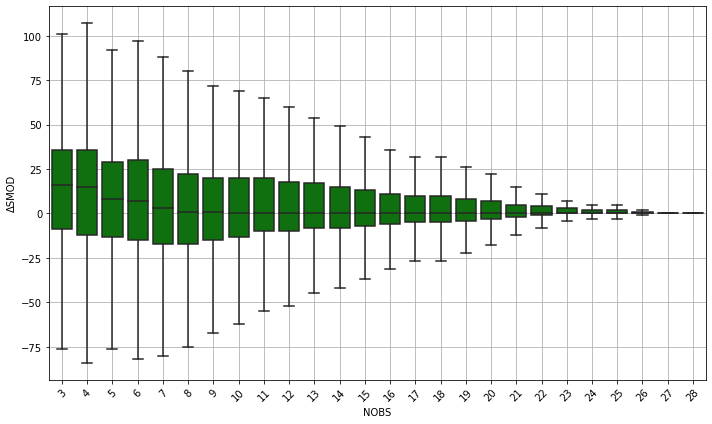

In [12]:
def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):

    mae = median_absolute_error( g['INSITU_SMOD'], g['SMOD'] )
    return pd.Series( dict( mae = mae) )



df_2 = df.query('NOBS <= 28 & SMOD > 0 & ALT >= 1050' )
df_temp = df_2.groupby(['NOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp["ΔSMOD_MEDIAN"] = df_2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_MEDIAN"] = df_2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_STD"] = df_2.groupby(['NOBS'])['ΔSMOD'].std()
df_temp["ΔSMOD_Q1"] = df_2.groupby(['NOBS'])['ΔSMOD'].quantile(0.25)
df_temp["ΔSMOD_Q3"] = df_2.groupby(['NOBS'])['ΔSMOD'].quantile(0.75)
df_temp["ΔSMOD_IQR"]  = df_temp.ΔSMOD_Q3  - df_temp.ΔSMOD_Q1 
df_temp["ΔSMOD_COUNT"] = df_2.groupby(['NOBS'])['ΔSMOD'].count()
df_temp["ci95_lo"] = df_temp.ΔSMOD_MEAN - 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ci95_hi"] = df_temp.ΔSMOD_MEAN + 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ΔSMOD_CI"]  = df_temp.ci95_hi  - df_temp.ci95_lo 
df_temp[["SMOD_R2",'SMOD_RMSE']]  =  df_2.groupby(['NOBS']).apply( r2_rmse_interval )
df_temp[['SMOD_MAE']]  =  df_2.groupby(['NOBS']).apply( mae_interval )
df_temp=df_temp.reset_index()

df_temp = df_temp.melt(id_vars=['NOBS'], value_vars=['SMOD_MAE','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')


fig, ax = plt.subplots()
df_2['NOBS'] = df_2['NOBS'].astype('int')
sn.boxplot(data=df_2,x='NOBS',y='ΔSMOD',showfliers = False,ax=ax,color='green')
ax.set_axisbelow(True)
ax.grid()
plt.xticks(rotation=45)
fig.set_figwidth(10)
fig.set_figheight(6)
plt.tight_layout()



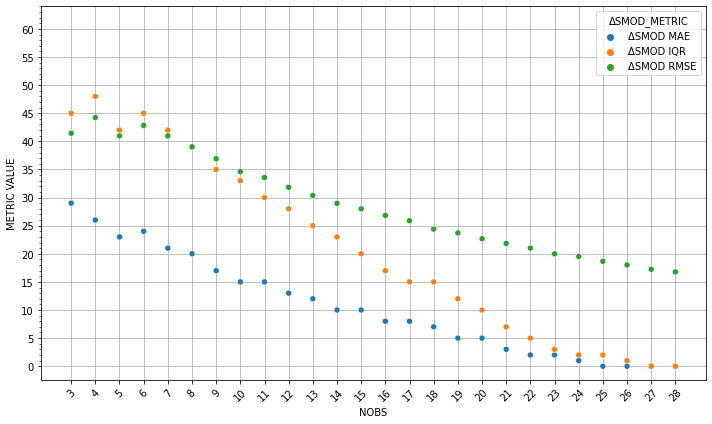

In [13]:
df_temp = df_temp.replace("SMOD_MAE","ΔSMOD MAE")
df_temp = df_temp.replace("ΔSMOD_IQR","ΔSMOD IQR")
df_temp = df_temp.replace("SMOD_RMSE","ΔSMOD RMSE")
fig, ax = plt.subplots()
ax.grid(axis="both",which="major")
ax.set_axisbelow(True)
sn.scatterplot(data=df_temp,x='NOBS',y='METRIC_VALUE',hue='ΔSMOD_METRIC',ax=ax)
#sn.regplot(data=df_temp.query("NOBS <= 25 & ΔSMOD_METRIC == 'ΔSMOD MAE'"),x='NOBS',y='METRIC_VALUE',order=1,scatter=False,ci=None,ax=ax)
#a,b = df_temp.query("NOBS <= 25 & ΔSMOD_METRIC == 'ΔSMOD MAE'").groupby(["ΔSMOD_METRIC"]).apply(lambda g: np.polyfit(g.NOBS, g.METRIC_VALUE, 1)).iloc[0]
#ax.text(5, 11, f"{round(a,2)}x + {round(b,2)}", fontsize=12,color=sn.color_palette("tab10", 10)[0])
#sn.regplot(data=df_temp.query("NOBS <= 26 & ΔSMOD_METRIC == 'ΔSMOD IQR'"),x='NOBS',y='METRIC_VALUE',order=1,scatter=False,ci=None,ax=ax)
#a,b = df_temp.query("NOBS <= 26 & ΔSMOD_METRIC == 'ΔSMOD IQR'").groupby(["ΔSMOD_METRIC"]).apply(lambda g: np.polyfit(g.NOBS, g.METRIC_VALUE, 1)).iloc[0]
#ax.text(19, 14, f"{round(a,2)}x + {round(b,2)}", fontsize=12,color=sn.color_palette("tab10", 10)[1])
#sn.regplot(data=df_temp.query("NOBS <= 26 & ΔSMOD_METRIC == 'ΔSMOD RMSE'"),x='NOBS',y='METRIC_VALUE',order=1,scatter=False,ci=None,ax=ax)
#a,b = df_temp.query("NOBS <= 26 & ΔSMOD_METRIC == 'ΔSMOD RMSE'").groupby(["ΔSMOD_METRIC"]).apply(lambda g: np.polyfit(g.NOBS, g.METRIC_VALUE, 1)).iloc[0]
#ax.text(15, 29, f"{round(a,2)}x + {round(b,2)}", fontsize=12,color=sn.color_palette("tab10", 10)[2])

ax.set_ylabel("METRIC VALUE")
ax.set_yticks(np.arange(0,65,5))
ax.set_yticks(np.arange(0,65,1),minor=True)
ax.set_xticks(np.arange(3,29))
plt.xticks(rotation=45)
fig.set_figwidth(10)
fig.set_figheight(6)
plt.tight_layout()

NOBS
3.0     16.0
4.0     15.0
5.0      7.0
6.0      5.0
7.0      2.0
8.0      0.0
9.0      0.0
10.0     0.0
11.0     0.0
12.0     0.0
13.0     0.0
14.0     0.0
15.0     0.0
16.0     0.0
17.0     0.0
18.0     0.0
19.0     0.0
20.0     0.0
21.0     0.0
22.0     0.0
23.0     0.0
24.0     0.0
25.0     0.0
26.0     0.0
27.0     0.0
28.0     0.0
Name: ΔSMOD, dtype: float64


/tmp/slurm-21714058/ipykernel_3157838/3365057146.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['NOBS'] = df2['NOBS'].astype('int')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


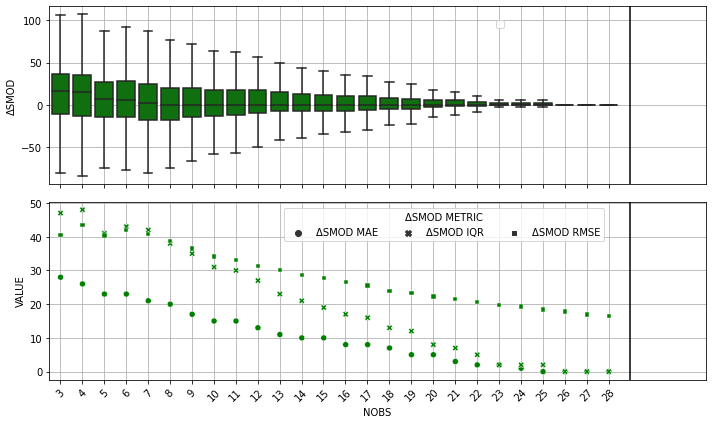

In [16]:
def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):

    mae = median_absolute_error( g['INSITU_SMOD'], g['SMOD'] )
    return pd.Series( dict( mae = mae) )




plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

df2 = df.query('NOBS <= 28 & SMOD > 0 & ALT >= 1350' )
df_temp = df2.groupby(['NOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp["ΔSMOD_MEDIAN"] = df2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_MEDIAN"] = df2.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_STD"] = df2.groupby(['NOBS'])['ΔSMOD'].std()
df_temp["ΔSMOD_Q1"] = df2.groupby(['NOBS'])['ΔSMOD'].quantile(0.25)
df_temp["ΔSMOD_Q3"] = df2.groupby(['NOBS'])['ΔSMOD'].quantile(0.75)
df_temp["ΔSMOD_IQR"]  = df_temp.ΔSMOD_Q3  - df_temp.ΔSMOD_Q1 
df_temp["ΔSMOD_COUNT"] = df2.groupby(['NOBS'])['ΔSMOD'].count()
df_temp["ci95_lo"] = df_temp.ΔSMOD_MEAN - 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ci95_hi"] = df_temp.ΔSMOD_MEAN + 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ΔSMOD_CI"]  = df_temp.ci95_hi  - df_temp.ci95_lo 
df_temp[["SMOD_R2",'SMOD_RMSE']]  =  df2.groupby(['NOBS']).apply( r2_rmse_interval )
df_temp[['SMOD_MAE']]  =  df2.groupby(['NOBS']).apply( mae_interval )
df_temp=df_temp.reset_index()

df_temp = df_temp.melt(id_vars=['NOBS'], value_vars=['SMOD_MAE','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')

print(df2.groupby("NOBS")["ΔSMOD"].median())


fig, ax = plt.subplots(2,1,sharex=True)
df2['NOBS'] = df2['NOBS'].astype('int')
g1 = sn.boxplot(data=df2,x='NOBS',y='ΔSMOD',showfliers = False,ax=ax[0],palette=['green'])
ax[0].set_axisbelow(True)
ax[0].grid()
ax[0].legend(bbox_to_anchor=[0.7, 0.95])
ax[0].axvline(26, color='black')
g1.set(xlabel=None)






df_temp = df_temp.replace("SMOD_MAE","ΔSMOD MAE")
df_temp = df_temp.replace("ΔSMOD_IQR","ΔSMOD IQR")
df_temp = df_temp.replace("SMOD_RMSE","ΔSMOD RMSE")
df_temp['DATASET'] = 'S2L8'
ax[1].grid(axis="both",which="major")
ax[1].set_axisbelow(True)
g2 = sn.scatterplot(data=df_temp,x='NOBS',y='METRIC_VALUE',style='ΔSMOD_METRIC',color='green', ax=ax[1])
plt.xticks(rotation=45)
offset = matptrans.ScaledTranslation(-0.91, 0, ax[1].figure.dpi_scale_trans)
trans = ax[1].collections[0].get_transform()
ax[1].collections[0].set_transform(trans + offset)
ax[1].legend(title="ΔSMOD METRIC",ncol=3,bbox_to_anchor=[0.35, 0.75])
ax[1].set_ylabel("VALUE")
ax[1].axvline(26, color='black')
fig.set_figwidth(10)
fig.set_figheight(6)
plt.tight_layout()
crop = matptrans.Bbox.from_extents(0, 0, 0.7, 1)
plt.savefig(op.join(plot_path,f'S2L8_sim.png'),format="png",transparent=False,facecolor='white', dpi=300)


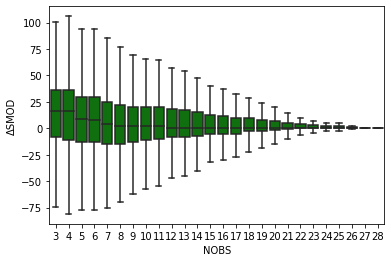

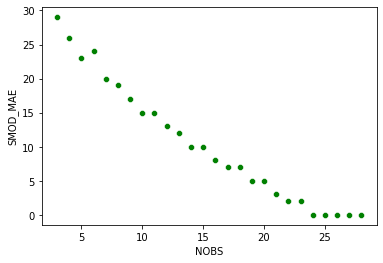

In [21]:
def r2_rmse_interval(g):
    r2 = r2_score( g['INSITU_SMOD'], g['SMOD'] )
    rmse = np.sqrt( mean_squared_error( g['INSITU_SMOD'], g['SMOD'] ))
    return pd.Series( dict(  r2 = r2, rmse = rmse) )

def mae_interval(g):

    mae = median_absolute_error( g['INSITU_SMOD'], g['SMOD'] )
    return pd.Series( dict( mae = mae) )




plot_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SYNTHESIS/ANALYSIS/SAFRAN/PLOTS"

df = df.query('NOBS <= 28 & SMOD > 0 ' )
df_temp = df.groupby(['NOBS'])['ΔSMOD'].mean().to_frame('ΔSMOD_MEAN')
df_temp["ΔSMOD_MEDIAN"] = df.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_MEDIAN"] = df.groupby(['NOBS'])['ΔSMOD'].median()
df_temp["ΔSMOD_STD"] = df.groupby(['NOBS'])['ΔSMOD'].std()
df_temp["ΔSMOD_Q1"] = df.groupby(['NOBS'])['ΔSMOD'].quantile(0.25)
df_temp["ΔSMOD_Q3"] = df.groupby(['NOBS'])['ΔSMOD'].quantile(0.75)
df_temp["ΔSMOD_IQR"]  = df_temp.ΔSMOD_Q3  - df_temp.ΔSMOD_Q1 
df_temp["ΔSMOD_COUNT"] = df.groupby(['NOBS'])['ΔSMOD'].count()
df_temp["ci95_lo"] = df_temp.ΔSMOD_MEAN - 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ci95_hi"] = df_temp.ΔSMOD_MEAN + 1.96*df_temp.ΔSMOD_STD/np.sqrt(df_temp.ΔSMOD_COUNT)
df_temp["ΔSMOD_CI"]  = df_temp.ci95_hi  - df_temp.ci95_lo 
df_temp[["SMOD_R2",'SMOD_RMSE']]  =  df.groupby(['NOBS']).apply( r2_rmse_interval )
df_temp[['SMOD_MAE']]  =  df.groupby(['NOBS']).apply( mae_interval )
df_temp=df_temp.reset_index()

#df_temp = df_temp.melt(id_vars=['NOBS'], value_vars=['SMOD_MAE','ΔSMOD_IQR','SMOD_RMSE'],var_name='ΔSMOD_METRIC', value_name='METRIC_VALUE')


fig, ax = plt.subplots()
df['NOBS'] = df['NOBS'].astype('int')
g1 = sn.boxplot(data=df,x='NOBS',y='ΔSMOD',showfliers=False,ax=ax,palette=['green'])





fig, ax = plt.subplots()
#df_temp = df_temp.rename(columns={"SMOD_MAE":"ΔSMOD MAE"})
df_temp['DATASET'] = 'S2L8'


g2 = sn.scatterplot(data=df_temp,x='NOBS',y='SMOD_MAE',color='green', ax=ax)




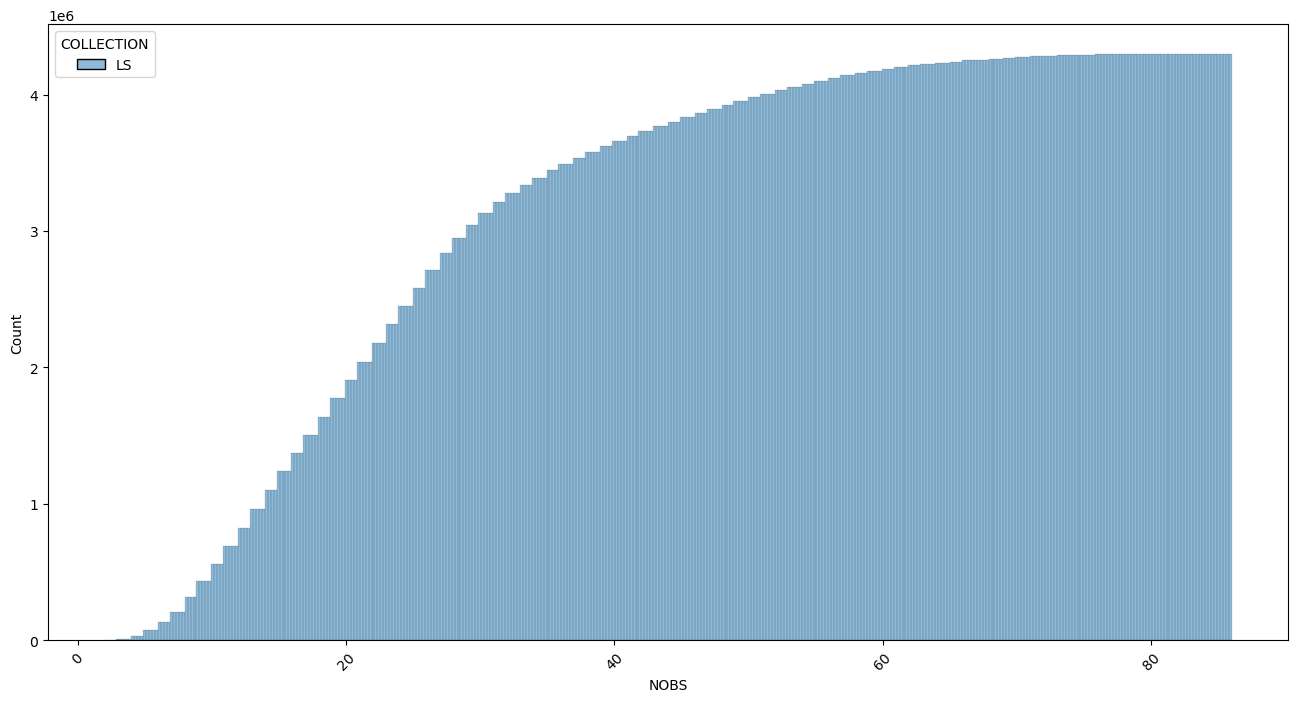

In [11]:

fig, ax = plt.subplots()
sn.histplot(data=df,x='NOBS',hue="COLLECTION",cumulative=True)
plt.xticks(rotation=45)
fig.set_figwidth(16)
fig.set_figheight(8)
plt.show()


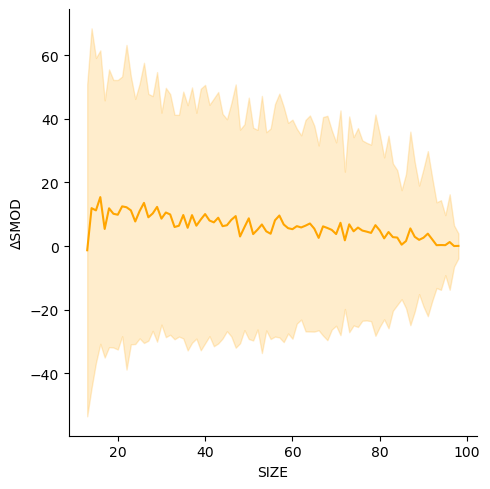

In [13]:


#fig, ax = plt.subplots()
sn.relplot(data=df.query("COLLECTION == 'LS' & SMOD > 0 "),x='SIZE',y='ΔSMOD',kind="line",errorbar="sd", color='orange')
#plt.xticks(rotation=45)
#fig.set_figwidth(20)
#fig.set_figheight(20)
#plt.show()

In [ ]:
# plot NOBS and SMOD residu
TCD_PATH="/datalake/static_aux/TreeCoverDensity"
tile="31TCH"
hydro_year=2017
tcd_array = (gdal.Open(os.path.join(TCD_PATH,tile,f'TCD_{tile}.tif'))).ReadAsArray()
full_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/FULL/{str(hydro_year)}"
#full_NOBS_path = glob.glob(os.path.join(full_path,'**','*NOBS*'),recursive=True)[0]
full_SMOD_path = glob.glob(os.path.join(full_path,'**','*SMOD*'),recursive=True)[0]
print(full_SMOD_path)
#full_NOBS_array = gdal.Open(full_NOBS_path).GetRasterBand(1).ReadAsArray().flatten()
full_SMOD_array = gdal.Open(full_SMOD_path).ReadAsArray()[tcd_array <= 50]
print("FULL SMOD",min(full_SMOD_array),max(full_SMOD_array))

list_nobs_range = []
list_nobs_range_index = []
list_residus = []
nobs_step = 10
for i,nobs_min in enumerate(range(0,101,nobs_step)):
    nobs_max = nobs_step + nobs_min
    list_nobs_range.append(f"[{str(nobs_min)};{str(nobs_max)}[")
    list_nobs_range_index.append(i)
    list_residus.append([])


reduced_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/S2_BIAS_ANALYSIS/{tile}/REDUCED/{str(hydro_year)}"
fig, axs = plt.subplots()
for N in os.listdir(reduced_path):
    print("Reduced timeserie",N)
    for I in os.listdir(os.path.join(reduced_path,N)):
        print("Iteration",I)
        SMOD_path = glob.glob(os.path.join(reduced_path,N,I,'**','*SMOD*'),recursive=True)[0]
        print(SMOD_path)
        NOBS_path = glob.glob(os.path.join(reduced_path,N,I,'**','*NOBS*'),recursive=True)[0]
        print(NOBS_path)
        NOBS_array = (gdal.Open(NOBS_path).ReadAsArray()[tcd_array <= 50]).flatten()
        print("NOBS",min(NOBS_array),max(NOBS_array))
        SMOD_array = (gdal.Open(SMOD_path).ReadAsArray()[tcd_array <= 50]).astype('int')
        print("SMOD",min(SMOD_array),max(SMOD_array))
        SMOD_residu =  (SMOD_array - full_SMOD_array).flatten()
        print("SMOD RESIDU",min(SMOD_residu),max(SMOD_residu))
        for i,nobs_min in enumerate(range(0,101,nobs_step)):
            nobs_max = nobs_step + nobs_min
            
            SMOD_residu_i = (SMOD_residu[(NOBS_array >= nobs_min) & (NOBS_array < nobs_max )]).tolist()
            if len(SMOD_residu_i) > 0:
                print(f"[{str(nobs_min)};{str(nobs_max)}[",min(SMOD_residu_i),max(SMOD_residu_i),len(SMOD_residu_i))
                list_residus[i].extend(SMOD_residu_i)

            
box_param = dict( patch_artist=True,
    flierprops=dict(marker='.', markeredgecolor='black',
    fillstyle=None), medianprops=dict(color='black'))
bx1 = axs.boxplot(list_residus, showfliers=True, positions=list_nobs_range_index, boxprops=dict(facecolor='tab:blue'),**box_param)
axs.legend([bx1["boxes"][0]], [f'tile {tile}\nhydro year {str(hydro_year)}'], loc='upper right')

#ax1.set_ylim(min_v-1,max_v+1)
#ax2.set_ylim(min_v-1,max_v+1)
# Format x ticks
axs.set_xticks(list_nobs_range_index)
axs.set_xticklabels([f'{list_nobs_range[i]}' for i in list_nobs_range_index],rotation=45)
axs.set_xlabel("NOBS")
axs.set_ylabel("Delta SMOD")
#plt.xticks(rotation=45)
plt.show()

            


        
        
        



In [ ]:

tile = "30TYN"
FSC_list_path = f"/home/ad/barrouz/datalake/S2-L2B-COSIMS/data/Snow/FSC/{tile}"
hydro_year = 2017



FSC_list = glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year)}*_FSCTOC.tif'),recursive=True) + glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year+1)}*_FSCTOC.tif'),recursive=True)
hydro_dict = {"Sep":[],"Oct":[],"Nov":[],"Dec":[],"Jan":[],"Feb":[],"Mar":[],"Apr":[],"May":[],"Jun":[],"Jul":[],"Aug":[]}


date_list = []
for FSC in FSC_list:
    fscdate = getDateFromStr(FSC)
    if fscdate in date_list : continue
    date_list.append(fscdate)
    m =  calendar.month_abbr[fscdate.month]
    if fscdate >= date(hydro_year,9,1) and fscdate < date(hydro_year+1,9,1):
        hydro_dict[m].append(FSC)


list_ratios = []
for m in hydro_dict:
    all_array = np.zeros((5490,5490))
    cloud_array = np.zeros((5490,5490))
    nodata_array = np.zeros((5490,5490))
    for fsc in hydro_dict[m]:
        fsc_array = (gdal.Open(fsc)).ReadAsArray()
        nodata_array = np.where(fsc_array == 255,1,nodata_array)
        all_array = np.where(fsc_array != 255,all_array +1,all_array)
        cloud_array = np.where(fsc_array == 205,cloud_array +1,cloud_array)
    ratio_array = cloud_array.astype(float)/all_array.astype(float)*100
    ratio_array = (np.where(nodata_array == 1,np.nan,ratio_array))
    ratio_array = ratio_array[~numpy.isnan(ratio_array)]
    list_ratios.append(numpy.average(ratio_array))
    

<BarContainer object of 12 artists>

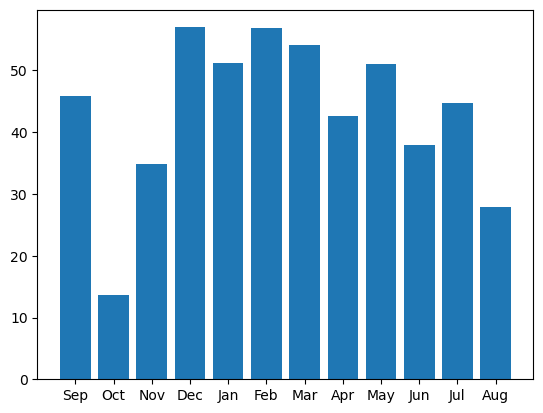

In [21]:
plt.bar(list(hydro_dict.keys()),list_ratios)

In [4]:

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(1986, 1, 1)
end_date = date(2015, 12, 31)
model = "TCD-ONLY_AVG-1200"



account = "cesbio"
log_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LOGS"
job_sh_path = "/home/ad/barrouz/WORKSPACE/TIMESERIES_PROJECT/synthesis_code/merge_swh_dlr.sh"
job_common_params =  " ".join(
    [
        "-A",account,
        " --job-name={}",
        " --time=00:59:59",
        " --quiet",
        "-N","1","-n","8",
        "--mem-per-cpu=8000M",
        "-o",log_path+"/{}",
        "--export=ALL,{}",job_sh_path
    ]
)

            
               
for mtn  in ["PYR","ALP"]: #"LANDSAT_tiles_2:

    for tile in S2_tiles[mtn]: #LANDSAT_tiles_2[mtn]:

        
            DLR_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/LANDSAT_QA_DLR/{mtn}_LIS"
            SWH_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/SWH_INFERENCE/{model}/{mtn}"

            wrs_list = LANDSAT_tiles_2[mtn][tile]
            for single_date in daterange(start_date, end_date):
                year = single_date.year
                month = single_date.month
                day= single_date.day
                SAT_list = []
                datestr = single_date.strftime("%Y%m%d")
                tile_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/DLR_SWH_MERGED/{model}"
                out_path = os.path.join(tile_path,mtn,tile,str(year),str(month),str(day),f"FSC_{datestr}T000000_ALL_{tile}")
                out_name = f"FSC_{datestr}T000000_ALL_{tile}_FSCTOC.tif"
                if not os.path.isfile(f"{out_path}/{out_name}"):
                    for wrs in wrs_list:
                        SAT_list.extend(glob.glob(os.path.join(DLR_path,f"FSC_{datestr}T*_{wrs}",f"FSC_{datestr}T*_{wrs}_FSCTOC.tif"),recursive=True))
                    SAT_list.extend(glob.glob(os.path.join(SWH_path,'*',str(year),str(month),str(day),'*',tile,"*","*FSCTOC*"),recursive=True))
                    if len(SAT_list) != 0:
                        #print(mtn,tile,datestr,SAT_list)
                        mkdir_p(out_path)         
                        minx = S2_tiles[mtn][tile]["MINX"]
                        miny = S2_tiles[mtn][tile]["MINY"]
                        maxx = S2_tiles[mtn][tile]["MAXX"]
                        maxy = S2_tiles[mtn][tile]["MAXY"]
                        epsg = S2_tiles[mtn][tile]["EPSG"]
                        options= f" -te {minx} {miny} {maxx} {maxy} "+ \
                        f" -tr 20 20 "+ \
                        f" -t_srs  EPSG:{epsg}"+ \
                        f" -r near "+ \
                        f" -srcnodata 255 -dstnodata 255 -co compress=deflate"


                        jobname=f"{mtn}_{tile}_{datestr}_mergeall"
                        list_sat_str = " ".join(SAT_list)
                        export =  ",".join([ f"out=\"{out_path}/{out_name}\"",f"in=\"{list_sat_str}\"",f"options=\"{options}\""])
                        os.system("sbatch "+job_common_params.format(jobname,jobname+".log",export))  

                        #gdal.Warp(os.path.join(out_path,f"FSC_{datestr}T000000_ALL_{tile}_FSCTOC.tif"),
                        #          SAT_list,
                        #          outputBounds= [S2_tiles[mtn][tile]["MINX"],S2_tiles[mtn][tile]["MINY"],S2_tiles[mtn][tile]["MAXX"],S2_tiles[mtn][tile]["MAXY"]],
                        #          xRes=20,yRes=20,
                        #          dstSRS="EPSG:"+S2_tiles[mtn][tile]["EPSG"],
                        #          resampleAlg="near",
                        #          srcNodata=255,dstNodata=255)

        


In [13]:
mtn="PYR"
tile = "30TYN"
FSC_list_path = f"/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/DLR_SWH_MERGED/TCD-BLUE_AVG-1200/{mtn}/{tile}"
ratio_path = "/home/ad/barrouz/zacharie/TIMESERIES_PROJECT/CLOUD_RATIOS"
dem_path = f"/home/ad/barrouz/Neige/DEM/S2__TEST_AUX_REFDE2_T{tile}_0001.DBL.DIR/S2__TEST_AUX_REFDE2_T{tile}_0001_ALT_R2.TIF"
dem_array = (gdal.Open(dem_path)).ReadAsArray()
tcd_path = f"/home/ad/barrouz/datalake/static_aux/TreeCoverDensity/{tile}/TCD_{tile}.tif"
tcd_array = (gdal.Open(tcd_path)).ReadAsArray()
hydro_dict = {"Sep":[],"Oct":[],"Nov":[],"Dec":[],"Jan":[],"Feb":[],"Mar":[],"Apr":[],"May":[],"Jun":[],"Jul":[],"Aug":[]}
driver = gdal.GetDriverByName('GTiff')

start_hydro_year=2010
end_hydro_year=2014
for hydro_year in range(start_hydro_year,end_hydro_year+1):
    FSC_list = glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year)}*_FSCTOC.tif'),recursive=True) + glob.glob(os.path.join(FSC_list_path,'**',f'*FSC_{str(hydro_year+1)}*_FSCTOC.tif'),recursive=True)
    for FSC in FSC_list:
        fscdate = getDateFromStr(FSC)
        m =  calendar.month_abbr[fscdate.month]
        if fscdate >= date(hydro_year,9,1) and fscdate < date(hydro_year+1,9,1):
            hydro_dict[m].append(FSC)


list_ratios = []
for m in hydro_dict:
    
    all_array = np.zeros((5490,5490))
    cloud_array = np.zeros((5490,5490))
    #nodata_array = np.zeros((5490,5490))
    l=len(hydro_dict[m])
    for i,fsc in enumerate(hydro_dict[m]):
        print(m,f"{(i+1)/l*100}/100",end="               \r")
        fsc_array = (gdal.Open(fsc)).ReadAsArray()
        #nodata_array = np.where(fsc_array == 255,1,nodata_array)
        all_array = np.where(fsc_array != 255,all_array +1,all_array)
        cloud_array = np.where(fsc_array == 205,cloud_array +1,cloud_array)
    ratio_tif =  os.path.join(ratio_path,f"{mtn}_{tile}_{m}_{str(start_hydro_year)}-{str(end_hydro_year)}_CLOUD_RATIO.tif")   
    ratio_array = (cloud_array.astype(float)/all_array.astype(float)*100).astype(int)
    outDs = driver.Create(ratio_tif,  5490, 5490 , 1, gdal.GDT_Byte)
    geotransform = ([S2_tiles[mtn][tile]['MINX'], 20, 0, S2_tiles[mtn][tile]['MAXY'], 0, -20 ])
    outBand = outDs.GetRasterBand(1)
    outBand.WriteArray(ratio_array)
    outDs.SetGeoTransform(geotransform) 
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(int(S2_tiles[mtn][tile]['EPSG']))
    outDs.SetProjection(srs.ExportToWkt())
    outDs.FlushCache()   
    ratio_array = (np.where(((tcd_array > 50) | ((dem_array >900)&(dem_array <1600)) ) ,np.nan,ratio_array))
    ratio_array = ratio_array[~numpy.isnan(ratio_array)]
    list_ratios.append(numpy.average(ratio_array))
    

/tmp/slurm-12027482/ipykernel_4064042/1895757932.py:37: RuntimeWarning: invalid value encountered in divide
  ratio_array = (cloud_array.astype(float)/all_array.astype(float)*100).astype(int)
/tmp/slurm-12027482/ipykernel_4064042/1895757932.py:37: RuntimeWarning: invalid value encountered in cast
  ratio_array = (cloud_array.astype(float)/all_array.astype(float)*100).astype(int)


<BarContainer object of 12 artists>

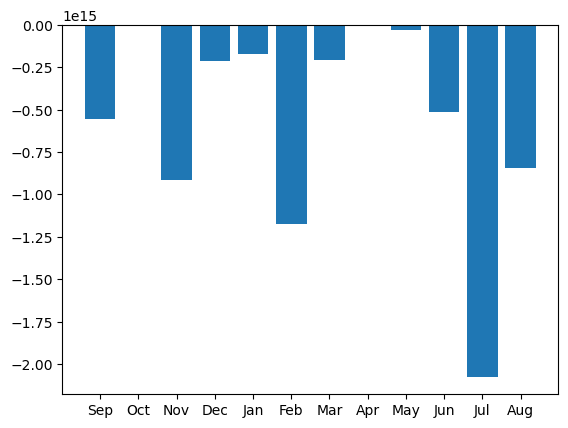

In [14]:
plt.bar(list(hydro_dict.keys()),list_ratios)